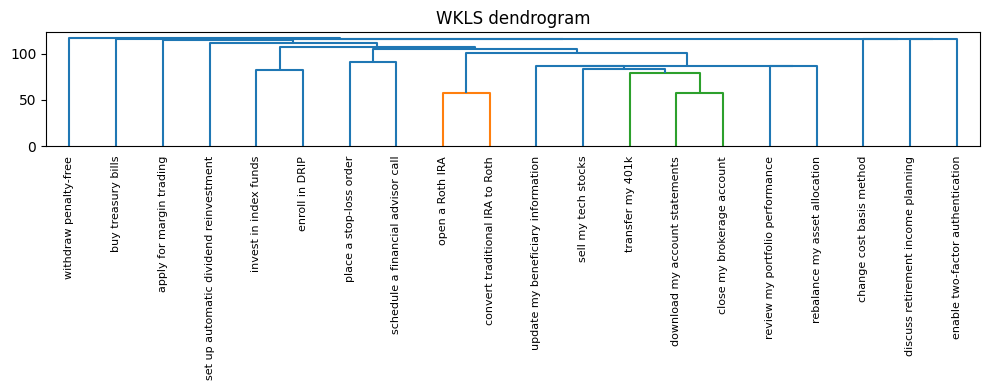

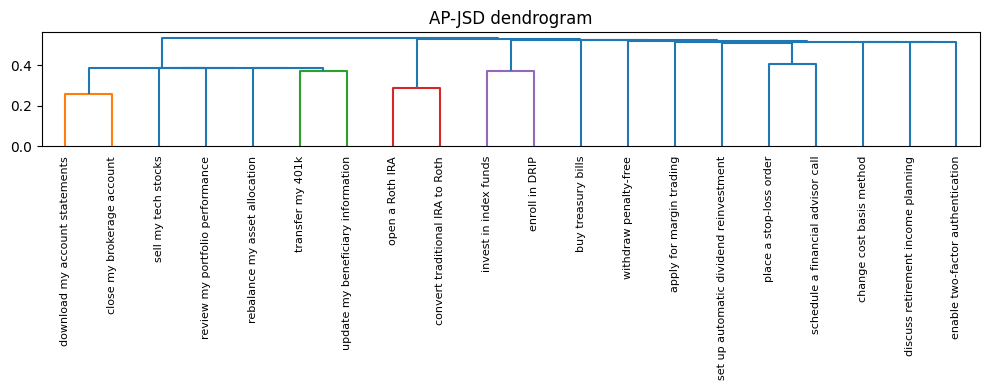


Divergence    CCC   Sil@5
WKLS          0.917  0.077
AP-JSD        0.966  0.163

>> Using AP-JSD for naming.


▣  Cluster 1 — 401K
   • transfer my 401k
   • sell my tech stocks
   • update my beneficiary information
   • review my portfolio performance
   • rebalance my asset allocation
   • download my account statements
   • close my brokerage account

▣  Cluster 2 — Ira
   • open a Roth IRA
   • convert traditional IRA to Roth

▣  Cluster 3 — Drip
   • invest in index funds
   • enroll in DRIP

▣  Cluster 4 — Trading
   • set up automatic dividend reinvestment
   • withdraw penalty-free
   • apply for margin trading
   • discuss retirement income planning
   • enable two-factor authentication
   • change cost basis method
   • place a stop-loss order
   • schedule a financial advisor call

▣  Cluster 5 — Buy
   • buy treasury bills


In [ ]:
# ================================================================
# COMPLETE PIPELINE: sparse clustering + metrics + cluster naming
# ================================================================
import importlib, subprocess, sys, re, time, math
from collections import Counter, defaultdict

# --- install deps silently if missing (Colab-friendly) -------------
for pkg in ["numpy", "scipy", "matplotlib", "scikit-learn"]:
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# --- std lib / scientific ------------------------------------------
import numpy as np
from scipy.sparse             import csr_matrix
from scipy.cluster.hierarchy  import linkage, dendrogram, cophenet, fcluster
from scipy.spatial.distance   import squareform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics          import silhouette_score
import matplotlib.pyplot as plt

# ================================================================
# 1.  SAMPLE DATA  (swap in your 750 phrases)
# ================================================================
phrases = [
    "open a Roth IRA",
    "transfer my 401k",
    "invest in index funds",
    "sell my tech stocks",
    "buy treasury bills",
    "update my beneficiary information",
    "set up automatic dividend reinvestment",
    "withdraw penalty-free",
    "convert traditional IRA to Roth",
    "review my portfolio performance",
    "apply for margin trading",
    "discuss retirement income planning",
    "rebalance my asset allocation",
    "download my account statements",
    "enable two-factor authentication",
    "change cost basis method",
    "place a stop-loss order",
    "enroll in DRIP",
    "schedule a financial advisor call",
    "close my brokerage account",
]

# ================================================================
# 2.  TOKENISE → SPARSE PROBABILITY MATRIX
# ================================================================
tok = re.compile(r"\b\w+\b").findall
tokenised = [tok(p.lower()) for p in phrases]

vocab  = sorted({t for s in tokenised for t in s})
v2i    = {w: i for i, w in enumerate(vocab)}
rows, cols, data = [], [], []
for r, sent in enumerate(tokenised):
    cnt = Counter(sent);  tot = sum(cnt.values())
    for w, c in cnt.items():
        rows.append(r); cols.append(v2i[w]); data.append(c / tot)
X = csr_matrix((data, (rows, cols)), shape=(len(phrases), len(vocab)))

# ================================================================
# 3.  GLOBAL STATS (df, idf, corpus background)
# ================================================================
N        = len(phrases)
df       = Counter(t for s in tokenised for t in set(s))
idf_vec  = np.array([math.log(N / df[w]) for w in vocab])
idf_rev  = {i: idf_vec[i] for i in range(len(vocab))}

bg_cnts  = Counter(t for s in tokenised for t in s)
bg_total = sum(bg_cnts.values())
bg       = np.array([bg_cnts.get(w, 0)/bg_total for w in vocab])
beta_vec = 0.2 * idf_vec / idf_vec.max()          # adaptive β
eps = 1e-9

# ================================================================
# 4.  THREE DIVERGENCES
# ================================================================
def wkls(u, v):
    val = 0.0
    for idx, pu in zip(u.indices, u.data):
        pv = v[0, idx]; w = idf_rev[idx]
        val += w * pu * math.log((pu+eps)/(pv+eps))
    for idx, pv in zip(v.indices, v.data):
        pu = u[0, idx]; w = idf_rev[idx]
        val += w * pv * math.log((pv+eps)/(pu+eps))
    return val

def ap_jsd(u, v):
    p = u.toarray().ravel();  q = v.toarray().ravel()
    p_ = (1-beta_vec)*p + beta_vec*bg
    q_ = (1-beta_vec)*q + beta_vec*bg
    m  = 0.5*(p_+q_)
    js = 0.5*np.sum(p_*np.log((p_+eps)/(m+eps))) + \
         0.5*np.sum(q_*np.log((q_+eps)/(m+eps)))
    return js

def renyi_jsd(u, v, alpha=0.8):
    p = u.toarray().ravel() + eps
    q = v.toarray().ravel() + eps
    m = 0.5*(p+q)
    num   = (m**alpha).sum()
    denom = 0.5*(p**alpha).sum() + 0.5*(q**alpha).sum()
    val   = (math.log(num) - math.log(denom)) / (alpha-1)
    return max(val, 0.0)

divergences = {
    "WKLS"   : wkls,
    "AP-JSD" : ap_jsd,
    #"Rényi-JSD": renyi_jsd,
}

# ================================================================
# 5.  BUILD CONDENSED DISTANCE  (shared helper)
# ================================================================
def condensed(div):
    n = X.shape[0]; out = np.empty(n*(n-1)//2)
    k = 0
    for i in range(n-1):
        ui = X.getrow(i)
        for j in range(i+1, n):
            d = div(ui, X.getrow(j))
            out[k] = d if d >= 0 else 0.0
            k += 1
    return out

# ================================================================
# 6.  DRAW DENDROGRAMS & COLLECT METRICS
# ================================================================
k_cut = 5
metrics = []
for name, f in divergences.items():
    D = condensed(f)
    Z = linkage(D, method="complete")

    # --- intrinsic metrics ------------------
    ccc, _ = cophenet(Z, D)
    labels_k = fcluster(Z, k_cut, criterion="maxclust")
    sil = silhouette_score(squareform(D), labels_k, metric="precomputed")
    metrics.append((name, ccc, sil, Z, labels_k, D))

    # --- plot dendrogram (comment out if running headless) ----
    plt.figure(figsize=(10,4))
    dendrogram(Z, labels=phrases, leaf_rotation=90, leaf_font_size=8)
    plt.title(f"{name} dendrogram")
    plt.tight_layout(); plt.show()

print(f"\n{'Divergence':12s}  CCC   Sil@{k_cut}")
for n, c, s, *_ in metrics:
    print(f"{n:12s}  {c:5.3f}  {s:5.3f}")

# pick the divergence with highest silhouette
best = max(metrics, key=lambda t: t[2])   # (name, ccc, sil, Z, labels, D)
print(f"\n>> Using {best[0]} for naming.\n")

best_Z, best_labels = best[3], best[4]

# ================================================================
# 7.  SIMPLE CLUSTER NAMING  (TF-IDF + heuristic)
# ================================================================
def top_ngrams(member_ids, n_top=4):
    texts = [phrases[i] for i in member_ids]
    tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english',
                            min_df=1).fit(texts)
    scores = np.asarray(tfidf.transform(texts).sum(axis=0)).ravel()
    best_idx = scores.argsort()[::-1][:n_top]
    return [tfidf.get_feature_names_out()[i] for i in best_idx]

def heuristic_label(cands):
    # pick the shortest candidate, title-case it
    return min(cands, key=len).title()

clusters = defaultdict(list)
for idx, cid in enumerate(best_labels):
    clusters[cid].append(idx)

cluster_names = {}
for cid, members in clusters.items():
    cands = top_ngrams(members)
    cluster_names[cid] = heuristic_label(cands)

# ================================================================
# 8.  DISPLAY RESULTING CLUSTERS + NAMES
# ================================================================
for cid, members in sorted(clusters.items()):
    print(f"\n▣  Cluster {cid} — {cluster_names[cid]}")
    for idx in members:
        print("   •", phrases[idx])


In [1]:
# ================================================================
# 1-CELL PIPELINE  —  clustering • metrics • HF zero-shot naming
# ================================================================
import importlib, subprocess, sys, re, math, json, os
from collections import Counter, defaultdict

# ── install lightweight deps silently ────────────────────────────
for pkg in ("numpy", "scipy", "matplotlib", "scikit-learn",
            "transformers", "sentencepiece", "accelerate"):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# ── std + scientific imports ─────────────────────────────────────
import numpy as np
from scipy.sparse             import csr_matrix
from scipy.cluster.hierarchy  import linkage, cophenet, fcluster
from scipy.spatial.distance   import squareform
from sklearn.metrics          import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt                                 # comment if headless
from transformers import pipeline                               # HF zero-shot naming

# ================================================================
# DATA  (swap in your 750 phrases)
# ================================================================
phrases = [
    "open a Roth IRA",
    "transfer my 401k",
    "invest in index funds",
    "sell my tech stocks",
    "buy treasury bills",
    "update my beneficiary information",
    "set up automatic dividend reinvestment",
    "withdraw penalty-free",
    "convert traditional IRA to Roth",
    "review my portfolio performance",
    "apply for margin trading",
    "discuss retirement income planning",
    "rebalance my asset allocation",
    "download my account statements",
    "enable two-factor authentication",
    "change cost basis method",
    "place a stop-loss order",
    "enroll in DRIP",
    "schedule a financial advisor call",
    "close my brokerage account",
]

# ================================================================
# TOKENISE → sparse probability matrix
# ================================================================
tokeniser = re.compile(r"\b\w+\b").findall
tokenised  = [tokeniser(t.lower()) for t in phrases]
vocab      = sorted({tok for sent in tokenised for tok in sent})
v2i        = {w: i for i, w in enumerate(vocab)}

rows, cols, data = [], [], []
for r, sent in enumerate(tokenised):
    cnt = Counter(sent); tot = sum(cnt.values())
    for w, c in cnt.items():
        rows.append(r); cols.append(v2i[w]); data.append(c / tot)
X = csr_matrix((data, (rows, cols)), shape=(len(phrases), len(vocab)))

# ================================================================
# global stats for divergences
# ================================================================
N = len(phrases)
df = Counter(tok for sent in tokenised for tok in set(sent))
idf_vec = np.array([math.log(N / df[w]) for w in vocab])
idf_map = {i: idf_vec[i] for i in range(len(vocab))}

bg_counts = Counter(tok for sent in tokenised for tok in sent)
bg_total  = sum(bg_counts.values())
bg        = np.array([bg_counts.get(w, 0)/bg_total for w in vocab])
beta_vec  = 0.2 * idf_vec / idf_vec.max()
eps = 1e-9

# ================================================================
# divergence definitions
# ================================================================
def wkls(u, v):
    out = 0.0
    for idx, pu in zip(u.indices, u.data):
        pv = v[0, idx]; w = idf_map[idx]
        out += w * pu * math.log((pu+eps)/(pv+eps))
    for idx, pv in zip(v.indices, v.data):
        pu = u[0, idx]; w = idf_map[idx]
        out += w * pv * math.log((pv+eps)/(pu+eps))
    return out

def ap_jsd(u, v):
    p = u.toarray().ravel(); q = v.toarray().ravel()
    p_ = (1-beta_vec)*p + beta_vec*bg
    q_ = (1-beta_vec)*q + beta_vec*bg
    m  = 0.5*(p_+q_)
    return 0.5*np.sum(p_*np.log((p_+eps)/(m+eps))) + \
           0.5*np.sum(q_*np.log((q_+eps)/(m+eps)))

def renyi_jsd(u, v, a=0.8):
    p = u.toarray().ravel()+eps; q = v.toarray().ravel()+eps
    m = 0.5*(p+q)
    num   = (m**a).sum()
    denom = 0.5*(p**a).sum() + 0.5*(q**a).sum()
    return max((math.log(num)-math.log(denom))/(a-1), 0.0)

divergences = {"WKLS": wkls, "AP-JSD": ap_jsd, #"Rényi-JSD": renyi_jsd
               }

def condensed(div):
    n = X.shape[0]; out = np.empty(n*(n-1)//2)
    k = 0
    for i in range(n-1):
        ui = X.getrow(i)
        for j in range(i+1, n):
            out[k] = div(ui, X.getrow(j)); k += 1
    return out

# ================================================================
# choose best divergence by silhouette (k=5)
# ================================================================
k_eval = 5
best_name, best_Z, best_D = None, None, None
best_sil = -1.0
for name, f in divergences.items():
    D = condensed(f);  Z = linkage(D, method="complete")
    sil = silhouette_score(squareform(D),
                           fcluster(Z, k_eval, criterion="maxclust"),
                           metric="precomputed")
    print(f"{name:8s} silhouette@{k_eval}: {sil:5.3f}")
    if sil > best_sil:
        best_name, best_Z, best_D, best_sil = name, Z, D, sil
print(f"\n>> chosen divergence: {best_name}\n")

# ================================================================
# build parent/child dictionaries from linkage
# ================================================================
n = len(phrases)
parents  = {}
children = defaultdict(list)
for idx, (a, b, _, _) in enumerate(best_Z, start=n):
    parents[int(a)] = parents[int(b)] = idx
    children[idx].extend([int(a), int(b)])

# ================================================================
# Hugging-Face zero-shot naming model
# ================================================================
hf_gen = pipeline("text2text-generation",
                  model="google/flan-t5-small",
                  max_length=8,
                  do_sample=False)

def zero_shot_name(cands):
    prompt = ("Give a concise 3-word category title for: " +
              "; ".join(cands))
    text = hf_gen(prompt, num_return_sequences=1)[0]["generated_text"]
    # take first ≤4 words
    return " ".join(text.split()[:4]).title()

def tfidf_terms(member_ids, k=6):
    texts = [phrases[i] for i in member_ids]
    vec   = TfidfVectorizer(ngram_range=(1,2), stop_words="english").fit(texts)
    scores = np.asarray(vec.transform(texts).sum(axis=0)).ravel()
    idxs   = scores.argsort()[::-1][:k]
    return [vec.get_feature_names_out()[i] for i in idxs]

# ================================================================
# build node representations bottom-up
# ================================================================
node = {i: {"id": i, "phrase": phrases[i]} for i in range(n)}

# internal nodes
for idx in range(n, n+len(best_Z)):
    # gather all descendant leaves
    stack = [idx]; leaves = []
    while stack:
        v = stack.pop()
        if v < n: leaves.append(v)
        else:     stack.extend(children[v])
    cands = tfidf_terms(leaves)
    node[idx] = {
        "id": idx,
        "name": zero_shot_name(cands),
        "children": [node[c] for c in children[idx]]
    }

root = node[n+len(best_Z)-1]

# ================================================================
# save + preview JSON
# ================================================================
with open("hierarchy.json", "w") as f:
    json.dump(root, f, indent=2)
print(json.dumps(root, indent=2)[:1200], "\n...\n(JSON truncated)")
print("\nHierarchy saved to hierarchy.json")


WKLS     silhouette@5: 0.077
AP-JSD   silhouette@5: 0.163

>> chosen divergence: AP-JSD



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{
  "id": 38,
  "name": "Account",
  "children": [
    {
      "id": 27,
      "name": "Account",
      "children": [
        {
          "id": 20,
          "name": "Account",
          "children": [
            {
              "id": 13,
              "phrase": "download my account statements"
            },
            {
              "id": 19,
              "phrase": "close my brokerage account"
            }
          ]
        },
        {
          "id": 26,
          "name": "401K",
          "children": [
            {
              "id": 24,
              "name": "Tech Stocks",
              "children": [
                {
                  "id": 3,
                  "phrase": "sell my tech stocks"
                },
                {
                  "id": 9,
                  "phrase": "review my portfolio performance"
                }
              ]
            },
            {
              "id": 25,
              "name": "Transfer 401K",
              "children": [
   

In [2]:
!pip install -q sentence-transformers transformers accelerate faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00


In [3]:
import json, pathlib, itertools, faiss, numpy as np
from sentence_transformers import SentenceTransformer

json_tree = json.load(open("hierarchy.json"))
model = SentenceTransformer("all-mpnet-base-v2")

leaf_records = []

def collect(node, path):
    if "phrase" in node:          # leaf
        leaf_records.append({"leaf_id": node["id"],
                             "path": " ▸ ".join(path),
                             "examples": [node["phrase"]]})
    else:
        for ch in node["children"]:
            collect(ch, path+[node["name"]])
collect(json_tree, [json_tree["name"]])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
embeds, leaf_ids = [], []
for rec in leaf_records:
    vec = model.encode(rec["examples"], normalize_embeddings=True).mean(axis=0)
    embeds.append(vec)
    leaf_ids.append(rec["leaf_id"])

embeds = np.stack(embeds).astype("float32")
index  = faiss.IndexFlatIP(embeds.shape[1])        # cosine (after L2-norm)
index.add(embeds)
id2rec = {rec["leaf_id"]: rec for rec in leaf_records}


In [5]:
def classify(text, top_k=3):
    q = model.encode(text, normalize_embeddings=True).astype("float32")
    D, I = index.search(q.reshape(1,-1), top_k)    # cosine scores
    results = []
    for score, idx in zip(D[0], I[0]):
        leaf = id2rec[leaf_ids[idx]]
        results.append({"score": float(score),
                        "leaf_id": leaf["leaf_id"],
                        "path": leaf["path"]})
    return results

test = "can I move my 401k over to fidelity?"
print(classify(test)[0])      # ⇒ likely “Account ▸ 401K ▸ Transfer 401K”


{'score': 0.6706591248512268, 'leaf_id': 1, 'path': 'Account ▸ Account ▸ Account ▸ 401K ▸ Transfer 401K ▸ 401K'}


In [6]:
def classify(text, top_k=3):
    q = model.encode(text, normalize_embeddings=True).astype("float32")
    D, I = index.search(q.reshape(1,-1), top_k)    # cosine scores
    results = []
    for score, idx in zip(D[0], I[0]):
        leaf = id2rec[leaf_ids[idx]]
        results.append({"score": float(score),
                        "leaf_id": leaf["leaf_id"],
                        "path": leaf["path"]})
    return results

test = "i want to trade in mutual funds"
print(classify(test)[0])      # ⇒ likely “Account ▸ 401K ▸ Transfer 401K”


{'score': 0.5176281929016113, 'leaf_id': 10, 'path': 'Account ▸ Account ▸ Roth ▸ Withdrawal Penalty ▸ Treasury ▸ Withdrawal Penalty ▸ Financial ▸ Financial'}
